# Spotify + Billboard Hot 100

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [2]:
from wrangle import *

# Acquire <a id="acquire"></a>

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

In [3]:
df = load_csv_file("merged_data_non_nulls.csv")

Found File


Loading merged_data_non_nulls.csv: 2it [00:00, 204.18it/s]


In [4]:
df = df.drop(columns = ['chart_position', 'instance','popularity',
       'consecutive_weeks', 'previous_week', 'peak_position',
       'worst_position'])

In [22]:
train, val, test = split_data(df)

(626, 22) (269, 22) (224, 22)


In [23]:
target = "time_on_chart"

In [26]:
X_train, y_train = isolate_target(train,target)
X_validate, y_validate = isolate_target(val,target)
X_test, y_test = isolate_target(test,target)

(626, 21) (626,)
(269, 21) (269,)
(224, 21) (224,)


In [27]:
X_train_scaled = scale_data(X_train)
X_validate_scaled = scale_data(X_validate)
X_test_scaled = scale_data(X_test)

In [28]:
to_dummies=['explicit']

In [29]:
X_train_scaled = dummies(X_train_scaled,to_dummies)
X_validate_scaled = dummies(X_validate_scaled,to_dummies)
X_test_scaled = dummies(X_test_scaled,to_dummies)

In [30]:
X_train_scaled.columns

Index(['duration_ms', 'explicit', 'year', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo'],
      dtype='object')

In [31]:
# parameters: f_regression stats test, give me 8 features
f_selector = SelectKBest(f_regression, k=4)

# find the top 8 X's correlated with y
f_selector.fit(X_train_scaled, y_train)

# boolean mask of whether the column was selected or not. 
feature_mask = f_selector.get_support()

# get list of top K features. 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
f_feature

['explicit', 'year', 'mode', 'speechiness']

In [32]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=4)

# fit the data using RFE
rfe.fit(X_train_scaled, y_train)

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()
rfe_feature

['duration_ms', 'energy', 'loudness', 'valence']

In [33]:
# view list of columns and their ranking

# get the ranks
var_ranks = rfe.ranking_
# get the variable names
var_names = X_train_scaled.columns.tolist()
# combine ranks and names into a df for clean viewing
rfe_ranks_df = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
# sort the df by rank
rfe_ranks_df.sort_values('Rank')

,Var,Rank
0,duration_ms,1
4,energy,1
6,loudness,1
12,valence,1
9,acousticness,2
2,year,3
1,explicit,4
10,instrumentalness,5
7,mode,6
8,speechiness,7


In [34]:
# Keeping Rank >= 7
modeling_features = rfe_ranks_df[rfe_ranks_df['Rank']<=7].sort_values('Rank')
modeling_features = [modeling_features.iloc[i][0] for i in range(10)]
modeling_features.append(to_dummies)
modeling_features = flatten(modeling_features)

In [35]:
# masking unnecessary features after RFE
X_train_scaled = X_train_scaled[modeling_features]
X_validate_scaled = X_validate_scaled[modeling_features]
X_test_scaled = X_test_scaled[modeling_features]

In [63]:
# Baseline
preds = pd.DataFrame()
preds['actual'] = y_train
preds['baseline'] = y_train.mean()

In [38]:
# Linear Model
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
preds['linear'] = lm.predict(X_train_scaled)

In [ ]:
# Specific Scaling for Lasso Lars
X_train_lasso_scale = scale_data(X_train,mode="standard")
X_train_lasso_scale = dummies(X_train_lasso_scale,to_dummies)

In [87]:
# Validate & Test
X_validate_lasso_scale = scale_data(X_validate,mode="standard")
X_test_lasso_scale = scale_data(X_test,mode="standard")

X_validate_lasso_scale = dummies(X_validate_lasso_scale,to_dummies)
X_test_lasso_scale = dummies(X_test_lasso_scale,to_dummies)
# Finished Product
# ================================================================
X_validate_lasso_scale = X_validate_lasso_scale[modeling_features]
X_test_lasso_scale = X_test_lasso_scale[modeling_features]

In [39]:
# Lasso Lars Model
lars = LassoLars(alpha=1.0)
lars.fit(X_train_lasso_scale, y_train)
preds['lasso_lars'] = lars.predict(X_train_lasso_scale)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


In [40]:
# Tweedie Model
glm = TweedieRegressor(power=1, alpha=0)
glm.fit(X_train_scaled, y_train)
preds['Tweedie'] = glm.predict(X_train_scaled)

In [56]:
score_chart = pd.DataFrame({'model':['baseline','linear','lasso_lars','Tweedie'],'score':[baseline_rmse,linear_rmse,lasso_lars_rmse,tweedie_rmse]})

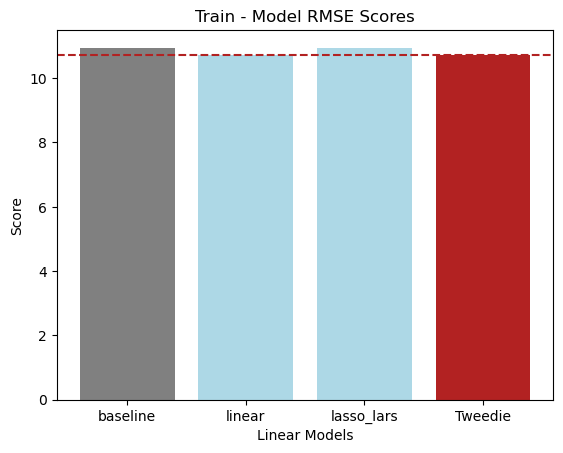

In [86]:
plt.bar(score_chart['model'],score_chart['score'],color=['grey', 'lightblue', 'lightblue', 'firebrick'])
plt.axhline(y = score_chart["score"].min(), color = 'firebrick', linestyle = '--')
plt.title("Train - Model RMSE Scores")
plt.xlabel('Linear Models')
plt.ylabel('Score')
plt.show()

# Validate

In [88]:
# Baseline
validate_preds = pd.DataFrame()
validate_preds['actual'] = y_validate
validate_preds['baseline'] = y_validate.mean()

In [89]:
validate_preds['linear'] = lm.predict(X_validate_scaled)
validate_preds['lasso_lars'] = lars.predict(X_validate_lasso_scale)
validate_preds['Tweedie'] = glm.predict(X_validate_scaled)

/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- danceability
- key
- liveness
- tempo

  warnings.warn(message, FutureWarning)


ValueError: X has 11 features, but LassoLars is expecting 14 features as input.

In [90]:
validate_baseline_rmse = (sqrt(mean_squared_error(validate_preds['actual'], validate_preds['baseline'])))
validate_linear_rmse = (sqrt(mean_squared_error(validate_preds['actual'], validate_preds['linear'])))
validate_lasso_lars_rmse = (sqrt(mean_squared_error(validate_preds['actual'], validate_preds['lasso_lars'])))
validate_tweedie_rmse = (sqrt(mean_squared_error(validate_preds['actual'], validate_preds['Tweedie'])))

KeyError: 'lasso_lars'

# Test

[Imports](#imports) - [Definitions](#definitions) - [Acquire](#acquire) - [Explore](#explore)  -  [Model](#model)  -  [Evaluate](#evaluate)  -  [Test](#test)  -  [Summary](#summary)  -  [Take Aways](#takeaways)

### Modeling Summary

* Out of the Linear Regression, Lasso Lars, and Tweedie Regressor models Tweedie Regressor performed better than baseline on train and validate
* The Logistic Regression model performed slightly better on validate data but was worse than baseline on either one.